In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import dateutil.relativedelta as rd

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
for Class in Base.classes.keys():
    print(Class)

measurement
station


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# some classes to display queries
def print_query(query):
    """
    Display all the variables in the item query.
    
        query -- A query, which in this case could be a class instance or a collection of class instances as a sqlalchemy.orm.query.Query.
    """
    if type(query) is sqlalchemy.orm.query.Query:
        for item in query:
            print_query(item)
    else:
        print(f"{'-'*4}class--{query.__class__.__name__}{'-'*4}")
        for key, value in query.__dict__.items():
            if not key.startswith("_"):
                print(f'{key} : {value}')

In [11]:
# Display some starter data
print_query(session.query(Measurement).first())
print_query(session.query(Station).limit(1))

----class--measurement----
date : 2010-01-01
id : 1
prcp : 0.08
station : USC00519397
tobs : 65.0
----class--station----
latitude : 21.2716
longitude : -157.8168
id : 1
elevation : 3.0
name : WAIKIKI 717.2, HI US
station : USC00519397


# Exploratory Precipitation Analysis

In [12]:
datetime_format = "%Y-%m-%d"

def to_datetime(value):
    """
    Convert the string into a datetime in a more compact function
    """
    # format using this template
    return dt.datetime.strptime(value, datetime_format)

# Find the most recent date in the data set.
most_recent_date = to_datetime(
    # Query the database on the class Measurement
    session.query(Measurement).\
        # order the column, use the decending argument
        order_by(Measurement.date.desc()).\
        # grab only the date column
        first().date)

most_recent_date.date()

datetime.date(2017, 8, 23)

In [13]:
def measurement_query_to_dataframe(query):
    """
    Convert a sqlalchemy query for the class measurement into a formatted dataframe
    """
    # read the query statment and send in the session
    df = pd.read_sql(query.statement, session.bind)
    # set the index to the id column
    df.set_index('id', inplace = True)
    # format the date column with the date format
    df['date'] = pd.to_datetime(df['date'], format=datetime_format)
    # return the dataframe
    return df

# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - rd.relativedelta(years = 1)
one_year_ago.date()

datetime.date(2016, 8, 23)

In [14]:
# Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(Measurement).\
    filter(
    # use the func.DATE to make sure your date is actually 
    # comparing datetime objects as opposed to a string objects
    Measurement.date >= func.DATE(one_year_ago.date()), 
    Measurement.date <= func.DATE(most_recent_date.date())
)
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_scores_df = measurement_query_to_dataframe(precipitation_scores)
# Sort the dataframe by date
precipitation_scores_df.sort_values(by = ["date"], inplace = True)
precipitation_scores_df

,station,date,prcp,tobs
id,,,,
2364,USC00519397,2016-08-23,0.00,81.0
8825,USC00517948,2016-08-23,NaN,80.0
14608,USC00519281,2016-08-23,1.79,77.0
7331,USC00514830,2016-08-23,0.05,80.0
5091,USC00513117,2016-08-23,0.15,76.0
...,...,...,...,...
12186,USC00519523,2017-08-22,0.00,82.0
7635,USC00514830,2017-08-23,0.00,82.0
2724,USC00519397,2017-08-23,0.00,81.0


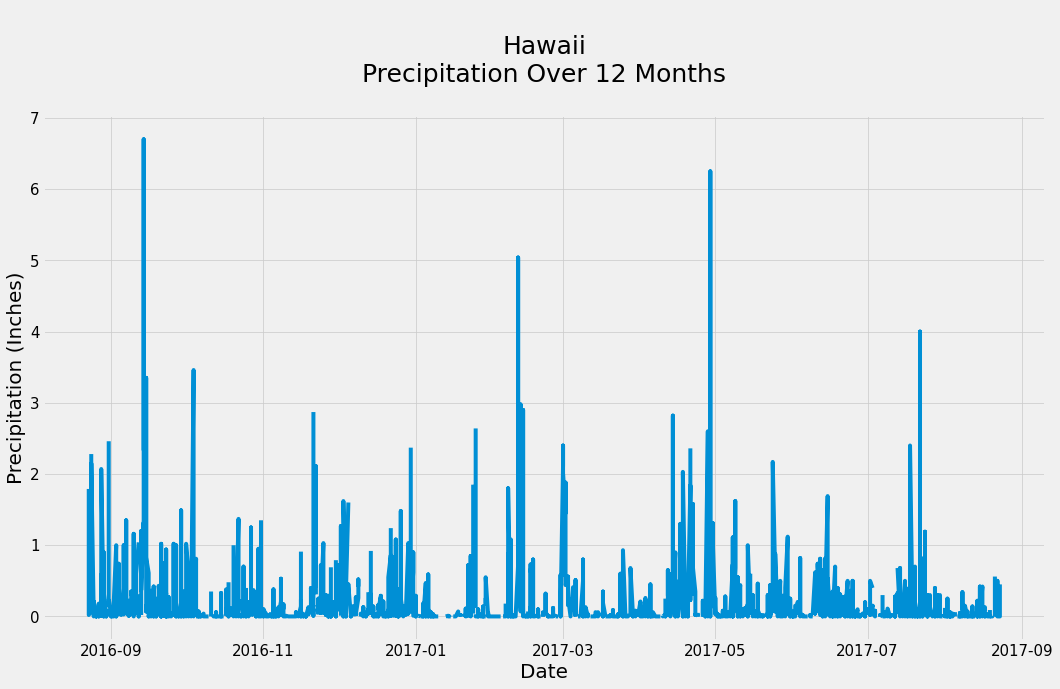

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(1, 1, figsize = (16,9))
plt.plot(
    precipitation_scores_df['date'],
    precipitation_scores_df['prcp']
)
plt.title(f'\nHawaii\nPrecipitation Over 12 Months\n', fontsize = (25))
plt.xlabel('Date', fontsize = (20))
plt.ylabel('Precipitation (Inches)', fontsize = (20))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(alpha = 0.75)
plt.savefig('Images/precipitation_over_12_months.png')
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_scores_df[["prcp"]].describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Measurement.station).distinct().count()
print(f"The station count is {station_count}")

The station count is 9


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stations_activity = session.query(
    # create a responce with the station as the first column
    Measurement.station, 
    # create a responce with the station count as the second column
    func.count(Measurement.station)
    # group by the station, so each unique instance in that column can be counted
).group_by(Measurement.station).\
order_by(
    # order by the function call we had, and add the desc call at the end
    func.count(Measurement.station).desc()
)

stations_activity_df = pd.DataFrame({"station":[s for s,c in stations_activity],
                                     "count":[c for s,c in stations_activity]})
stations_activity_df.set_index('station', inplace = True)
stations_activity_df

,count
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = stations_activity_df.iloc[0].name
# query the server with the most active station
# list data as min, max, and mean/avg
station_tobs_min, station_tobs_max, station_tobs_mean = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
# sort by date
).filter(Measurement.station == most_active_station).\
    order_by(Measurement.date).first()

print(f"The most active station is {most_active_station},")
print(f"\twith a temperature min of {round(station_tobs_min, 2)}°F,")
print(f"\ta temperature max of {round(station_tobs_max, 2)}°F,")
print(f"\tand an average temperature of {round(station_tobs_mean, 2)}°F")

The most active station is USC00519281,
	with a temperature min of 54.0°F,
	a temperature max of 85.0°F,
	and an average temperature of 71.66°F


In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
station_temperature_observation = session.query(Measurement).filter(
    # filter most active station
    Measurement.station == most_active_station,
    # use the func.DATE to make sure your date is actually 
    # comparing datetime objects as opposed to a string objects
    Measurement.date >= func.DATE(one_year_ago.date()), 
    Measurement.date <= func.DATE(most_recent_date.date())
)
station_temperature_observation_df = measurement_query_to_dataframe(station_temperature_observation)
station_temperature_observation_df

,station,date,prcp,tobs
id,,,,
14608,USC00519281,2016-08-23,1.79,77.0
14609,USC00519281,2016-08-24,2.15,77.0
14610,USC00519281,2016-08-25,0.06,80.0
14611,USC00519281,2016-08-26,0.01,80.0
14612,USC00519281,2016-08-27,0.12,75.0
...,...,...,...,...
14955,USC00519281,2017-08-14,0.00,77.0
14956,USC00519281,2017-08-15,0.32,77.0
14957,USC00519281,2017-08-16,0.12,76.0


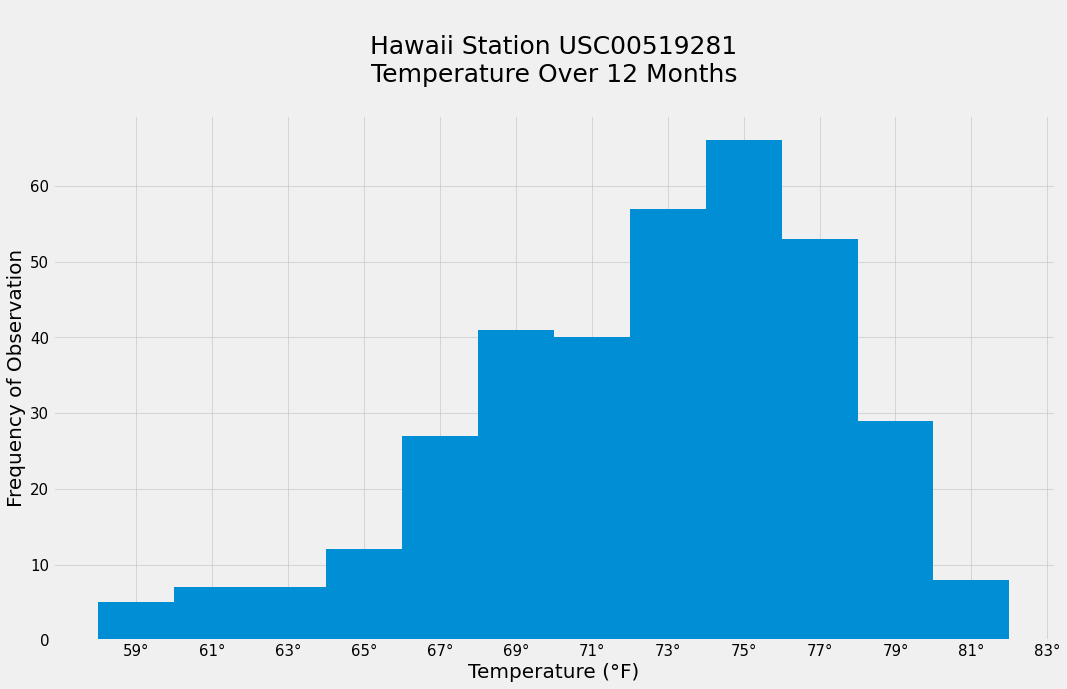

In [21]:
# plot the results as a histogram
fig, ax = plt.subplots(1, 1, figsize = (16,9))
count, bins, patches = plt.hist(
    station_temperature_observation_df['tobs'], 
    align = 'left',
    bins = 12
)
ax.set_xticks(bins)
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}°')) 
plt.title(f'\nHawaii Station {most_active_station}\nTemperature Over 12 Months\n', fontsize = (25))
plt.xlabel('Temperature (°F)', fontsize = (20))
plt.ylabel('Frequency of Observation', fontsize = (20))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(alpha = 0.75)
plt.savefig('Images/station_temperature_over_12_months.png')
plt.show()

# Close session

In [22]:
# Close Session
session.close()